Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
               price  freight_value  product_weight_g  product_photos_qty
count  110163.000000  110163.000000     110163.000000       108644.000000
mean      119.974290      19.949428       2089.535443            2.210808
std       182.238392      15.700233       3741.378858            1.721828
min         0.850000       0.000000          0.000000            1.000000
25%        39.900000      13.080000        300.000000            1.000000
50%        74.900000      16.260000        700.000000            1.000000
75%       134.185000      21.150000       1800.000000            3.000000
max      6735.000000     409.680000      40425.000000           20.000000


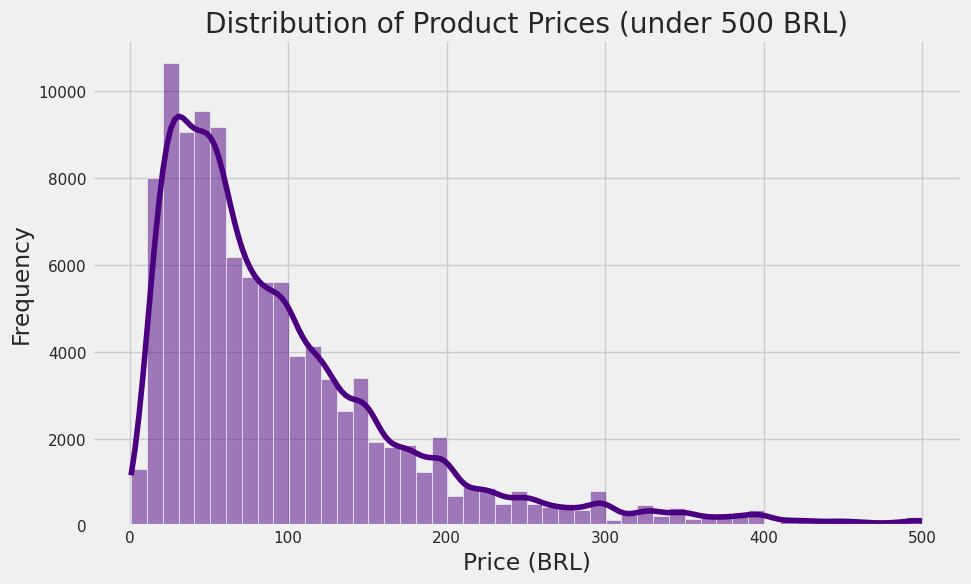

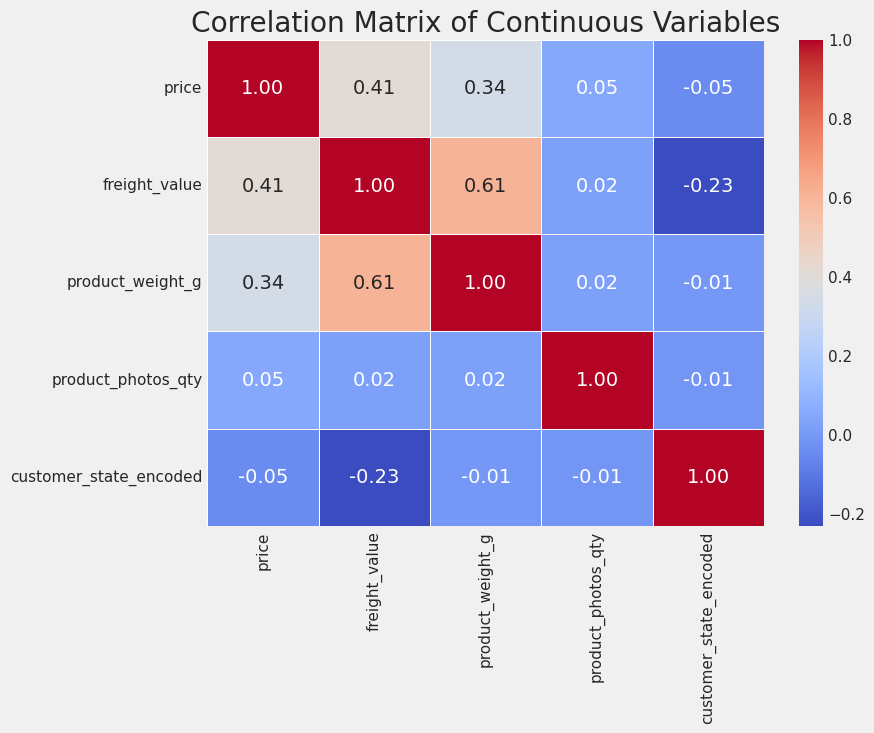

/tmp/ipython-input-1398710662.py:74: BokehDeprecationWarning:

'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.



In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import kagglehub
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

orders = pd.read_csv(f"{path}/olist_orders_dataset.csv")
order_items = pd.read_csv(f"{path}/olist_order_items_dataset.csv")
customers = pd.read_csv(f"{path}/olist_customers_dataset.csv")
products = pd.read_csv(f"{path}/olist_products_dataset.csv")

df = orders.merge(order_items, on='order_id').merge(customers, on='customer_id').merge(products, on='product_id')

df.dropna(subset=['order_approved_at', 'order_delivered_customer_date', 'product_weight_g'], inplace=True)

le = LabelEncoder()
df['customer_state_encoded'] = le.fit_transform(df['customer_state'])

summary_stats = df[['price', 'freight_value', 'product_weight_g', 'product_photos_qty']].describe()
print(summary_stats)

plt.figure(figsize=(10, 6))
sns.histplot(df['price'][df['price'] < 500], bins=50, kde=True, color='indigo')
plt.title('Distribution of Product Prices (under 500 BRL)')
plt.xlabel('Price (BRL)')
plt.ylabel('Frequency')
plt.show()

corr_cols = ['price', 'freight_value', 'product_weight_g', 'product_photos_qty', 'customer_state_encoded']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Continuous Variables')
plt.show()

X = df[['product_weight_g']].values
y = df['freight_value'].values
reg = LinearRegression().fit(X, y)
df['predicted_freight'] = reg.predict(X)

sample_df = df.sample(2000, random_state=42)
fig_px = px.scatter(sample_df, x='product_weight_g', y='freight_value',
                    trendline="ols", title="Regression: Freight Value vs. Product Weight",
                    labels={'product_weight_g': 'Product Weight (g)', 'freight_value': 'Freight Value (BRL)'},
                    opacity=0.6)
fig_px.show()

customer_spend = df.groupby('customer_unique_id').agg({'price': 'sum', 'freight_value': 'sum'}).reset_index()

scaler = StandardScaler()
scaled_spend = scaler.fit_transform(customer_spend[['price', 'freight_value']])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_spend['cluster'] = kmeans.fit_predict(scaled_spend)
customer_spend['cluster'] = customer_spend['cluster'].astype(str)

sample_cluster = customer_spend.sample(1500, random_state=42)

p = figure(title="K-Means Clustering: Customer Spend on Price vs. Freight",
           x_axis_label='Total Price Spend (BRL)',
           y_axis_label='Total Freight Spend (BRL)',
           width=800, height=500)

colors = {'0': 'tomato', '1': 'seagreen', '2': 'royalblue'}
p.circle(sample_cluster['price'], sample_cluster['freight_value'],
         color=[colors[x] for x in sample_cluster['cluster']],
         size=8, alpha=0.6)

show(p)